# Text Classification on Song Lyrics

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Part II : Model

## 1. Introduction

This project aims at building a text classification model on song lyrics. The task is to predict the artist from song text. We will focus on two artist from the "Heavy Metal" genre: Ronnie James Dio (Dio) and Ozzy Osbourne (Ozzy). Training such a model requires first of all that we collect our own lyrics dataset. This feat has already been achieved in Part I of the project by making use of the website:  http://www.darklyrics.com. 

In Part II, we will train various models on the dataset we collected. We will select the best model hyperparameter tuning with k-fold cross validation. 

### 1.1 Load Packages

In [1]:
# data processing libraries
import numpy as np
import pandas as pd

In [70]:
# plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set() # set seaborn as default style

In [3]:
# language pre-processing libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
import string

[nltk_data] Downloading package stopwords to C:\Users\Rakibur
[nltk_data]     Rahman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
# machine learning libraries
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay 

In [45]:
# other libraries
import time
import joblib
import warnings
warnings.filterwarnings("ignore")

### 1.2 User Defined Functions

In [6]:
# text pre-processing function

def text_preprocess(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns cleaned text in as string
    """
    # removing punctuation
    no_punc = [char for char in text if char not in string.punctuation]

    # rejoining the characters to form the string
    no_punc = ''.join(no_punc)
    
    # removing stopwords
    clean = [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]
    
    # rejoining characters to form string
    clean = ' '.join(clean)
    
    return clean

In [7]:
# function for grid serach serach of best hyperparameters

def model_fit(clf_name,X_,y_,cv_):
    '''This function finds best estimator for a given classifier'''
   
    grid = GridSearchCV(clf[clf_name], param_grid=hp[clf_name], return_train_score=True,
                        scoring='accuracy', n_jobs=-1, cv=cv_)

    #     pipeline = Pipeline([('bow',CountVectorizer()), ('tfidf',TfidfTransformer()), ('grid',grid)])
    pipeline = Pipeline([('c_vec',CountVectorizer()), ('grid',grid)])
    
    ti = time.time()
    
    pipeline.fit(X_,y_) # training the model
    
    tf = time.time()
    min_,sec_ = [int((tf-ti)/60),int((tf-ti)%60)]
    print(f'hyperparameter tuning took: {min_} min {sec_} sec')
    
    best_params = grid.best_params_
    print(f'best hyperparameters: {best_params}')
    
    best_score = round(grid.best_score_,3)
    print(f'best validation score: {best_score}')
    
    best_pipeline = Pipeline([('c_vec',CountVectorizer()), ('grid',grid.best_estimator_)])
    return best_pipeline

In [57]:
# function for voting classifier

def voting_(voter_list,vote_type,models):
    '''This function creates a voting classifier of a number of estimators,
    which is subsequently trained and tested'''
    
    # creating voting classifier
    estimator_list = []
    for clf_name in voter_list:
        estimator_list.append((clf_name,models[clf_name]))
    voting_clf = VotingClassifier(estimators=estimator_list,voting=vote_type)
    
    # training the voting classifier
    voting_model = voting_clf.fit(X,y)
    
    return voting_model

## 2. Data Exploration

#### Get Data

In [8]:
# read data from file
df = pd.read_csv('songlines.csv')

#### Dataframe Quick Check

In [9]:
# check head
df.head()

,line,artist
0,It's the same old song,Dio
1,you gotta be somewhere at sometime,Dio
2,and they'll never let you fly,Dio
3,It's like broken glass,Dio
4,you get cut before you see it,Dio


In [10]:
# check tail
df.tail()

,line,artist
9006,And I don't walk on water (oh no),Ozzy
9007,I don't walk on water (oh no),Ozzy
9008,My dromedary dreams as wet as oceans,Ozzy
9009,With sand dunes bearing seeds she set in motion,Ozzy
9010,My dromedary dreams my dromedary dreams my dro...,Ozzy


In [11]:
# some information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   line    9011 non-null   object
 1   artist  9011 non-null   object
dtypes: object(2)
memory usage: 140.9+ KB


#### Check Target Variable 

In [12]:
df['artist'].value_counts(normalize=True)

Ozzy    0.599157
Dio     0.400843
Name: artist, dtype: float64

Comment: Dataset is no highly imbalanced, but not very balanced either. ROC or f1 score might be a better measure than accuracy

## 3. Data Pre-processing

In [13]:
# create pre-processed song-line column

ti = time.time()

df['line_pp'] = df['line'].apply(text_preprocess) # pre-processing step

tf = time.time()
min_,sec_ = [int((tf-ti)/60),int((tf-ti)%60)]

print(f'elapsed time: {min_} min {sec_} sec')

elapsed time: 0 min 18 sec


In [14]:
# check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   line     9011 non-null   object
 1   artist   9011 non-null   object
 2   line_pp  9011 non-null   object
dtypes: object(3)
memory usage: 211.3+ KB


## 4. Model Building

### 4.1 Feature/Target Variable Separation

In [15]:
# feature: text
X = df['line_pp']

# label: artist name
y = df['artist'].map({'Dio':1,'Ozzy':0})

In [16]:
print(f'feature data: {X.shape}')
print(f'target data : {y.shape}') 

feature data: (9011,)
target data : (9011,)


### 4.2 Baseline Model

All labels belong to the majority class 0 (all lines belong to Ozzy)

In [17]:
# baseline model predictions
yb_pred = np.zeros(df['artist'].shape[0])

In [18]:
# baseline scores
acc_b = round(accuracy_score(y,yb_pred),3)
auc_b = round(roc_auc_score(y,yb_pred),3)
f1_b = round(f1_score(y,yb_pred),3)
print(f'accuracy: {acc_b}, AUC: {auc_b}, f1_score: {f1_b}')

accuracy: 0.599, AUC: 0.5, f1_score: 0.0


Comment: One must have accuracy > 0.60 and AUC > 0.50 in order for a model to be good

### 4.3 Model Selection

Below we do hyperparameter tuning with cross validation of various classfiers

In [40]:
# collect three classifiers: PassiveAggressive, 
clf = {'LRC': LogisticRegression(),
       'PAC': PassiveAggressiveClassifier(),
       'NBC': MultinomialNB(),
       'DTC': DecisionTreeClassifier(),
       'RFC': RandomForestClassifier()}

In [41]:
# hyperparameter grid
hp = {'LRC': dict(C=10.**np.arange(-3,3), penalty=['l2','none']),
      'PAC': dict(C = 10.**np.arange(-3, 3),max_iter = list(range(1_000,10_100,100))),
      'NBC': dict(alpha=[0.5,1.0,1.5,2.0,2.5], fit_prior=[True,False], class_prior=[None]), 
      'DTC': dict(criterion=['gini','entropy'], min_samples_leaf=list(range(1,10)), max_depth=list(range(2,14,2))),
      'RFC': dict(n_estimators=[10,50,100,500,1000], max_features=['auto','sqrt','log2'])}

#### 4.3.1 Logistic Regression

In [21]:
LRC_model = model_fit('LRC',X,y,cv_=10)

hyperparameter tuning took: 0 min 8 sec
best hyperparameters: {'C': 1.0, 'penalty': 'l2'}
best validation score: 0.704


#### 4.3.2 Passive-Aggressive Classifier

In [22]:
PAC_model = model_fit('PAC',X,y,cv_=10)

hyperparameter tuning took: 1 min 0 sec
best hyperparameters: {'C': 0.01, 'max_iter': 1000}
best validation score: 0.705


#### 4.3.3 Naive Bayes Classifier

In [38]:
NBC_model = model_fit('NBC',X,y,cv_=10)

hyperparameter tuning took: 0 min 0 sec
best hyperparameters: {'alpha': 2.0, 'class_prior': None, 'fit_prior': True}
best validation score: 0.691


#### 4.3.4 Decision Tree Classifier

In [42]:
DTC_model = model_fit('DTC',X,y,cv_=10)

hyperparameter tuning took: 0 min 23 sec
best hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4}
best validation score: 0.635


#### 4.3.5 Random Forest Classifier

In [24]:
RFC_model = model_fit('RFC',X,y,cv_=10)

hyperparameter tuning took: 26 min 26 sec
best hyperparameters: {'max_features': 'log2', 'n_estimators': 500}
best validation score: 0.708


### 4.4 Model Training (Best Hyperparameters)

#### Train Model

In [43]:
# Logictic Regression
LRC_best = LRC_model.fit(X,y)

# Passive Aggressive Classifier
PAC_best = PAC_model.fit(X,y)

# Naive Bayes Classifier
NBC_best = NBC_model.fit(X,y)

# Decision Tree Classifier
DTC_best = DTC_model.fit(X,y)

# Random Forest Classifier
RFC_best = RFC_model.fit(X,y)

#### Save Model

In [47]:
# Logictic Regression
joblib.dump(LRC_best, 'LRC_best.pkl')

# Passive Aggressive Classifier
joblib.dump(PAC_best, 'PAC_best.pkl')

# Naive Bayes Classifier
joblib.dump(NBC_best, 'NBC_best.pkl')

# Decision Tree Classifier
joblib.dump(DTC_best, 'DTC_best.pkl')


# Random Forest Classifier
joblib.dump(RFC_best, 'RFC_best.pkl')

None

## 5. Model Performance

#### Model collection

In [50]:
# Logictic Regression
model_LRC = joblib.load('LRC_best.pkl')

# Passive Aggressive Classifier
model_PAC = joblib.load('PAC_best.pkl')

# Naive Bayes Classifier
model_NBC = joblib.load('NBC_best.pkl')

# Decision Tree Classifier
model_DTC = joblib.load('DTC_best.pkl')

# Random Forest Classifier
model_RFC = joblib.load('RFC_best.pkl')

#### Cross validation

In [51]:
# cross validation score

models = {'LRC':model_LRC, 'PAC':model_PAC, 'NBC':model_NBC, 'DTC':model_DTC, 'RFC':model_RFC}

print('validation accuracy:')
for model in models:
    cross_score = cross_val_score(estimator=models[model], X=X, y=y, cv=5, scoring='accuracy')
    avg_score = round(cross_score.mean(),6)
    print(f'{model}: {avg_score}')

validation accuracy:
LRC: 0.69359
PAC: 0.690372
NBC: 0.685046
DTC: 0.63034
RFC: 0.696479


## 6. Prediction

In [52]:
# enter song line of Dio or Ozzy
song_line = 'Train will arrive'

In [53]:
# pre-process
song_line_pp = text_preprocess(song_line)
text = [song_line_pp]

In [54]:
# predict
for model in models:
    y_pred = models[model].predict(text)[0]
    if y_pred==1:
        atrist_pred = 'Dio'
    if y_pred==0:
        atrist_pred = 'Ozzy'
    print(f'{model}: {atrist_pred}')

LRC: Ozzy
PAC: Ozzy
NBC: Ozzy
DTC: Ozzy
RFC: Ozzy


## 7. Voting Classifier

#### Creation

In [58]:
# voter list
voter_list = [classifier for classifier in clf]
voter_list.remove('LRC')
voter_list.remove('DTC')
print(f'voter list: {voter_list}')

voter list: ['PAC', 'NBC', 'RFC']


#### Training

In [59]:
# trained hard voting model
hard_voting_model = voting_(voter_list,'hard',models)

In [60]:
# trained soft voting model
# soft_voting_model = voting_(voter_list,'soft',models)

#### Performance

In [66]:
# cross validation score

voting_models = {'Hard_Voting':hard_voting_model}
# voting_models = {'Hard_Voting':hard_voting_model, 'Soft_Voting':soft_voting_model}

print('validation accuracy:')
for model in voting_models:
    cross_score = cross_val_score(estimator=voting_models[model], X=X, y=y, cv=5, scoring='accuracy')
    avg_score = round(cross_score.mean(),6)
    print(f'{model}: {avg_score}')

validation accuracy:
Hard_Voting: 0.699473


Hard_Voting
accuracy: 0.897
precision: 0.91
precision: 0.91
f1_score: 0.865
AUC: 0.885
confusion_matrix:
[[5106  293]
 [ 637 2975]]


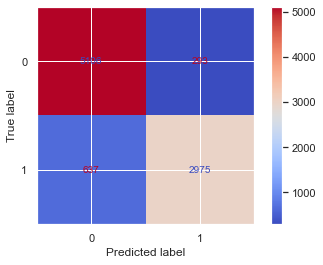

In [71]:
# evaluation of metrics

for model in voting_models:
    print(model)
    y_pred = voting_models[model].predict(X)
    
    accuracy = round(accuracy_score(y,y_pred),3)
    print(f'accuracy: {accuracy}')
    
    precision = round(precision_score(y,y_pred),3)
    print(f'precision: {precision}')
    
    recall = round(recall_score(y,y_pred),3)
    print(f'precision: {precision}')
    
    f1 = round(f1_score(y,y_pred),3)
    print(f'f1_score: {f1}')
    
    auc = round(roc_auc_score(y,y_pred),3)
    print(f'AUC: {auc}')
    
    cm = confusion_matrix(y,y_pred)
    print('confusion_matrix:')
    print(cm)
    
    #print confusion matrix
    ConfusionMatrixDisplay.from_estimator(voting_models[model], X, y, cmap='coolwarm')

#### Predictions

In [72]:
# function to predict artist

def predict_artist(line):
    '''This function predicts artist from song line'''
    # pre-process
    song_line_pp = text_preprocess(line)
    text = [song_line_pp]
    # predict
    y_pred = hard_voting_model.predict(text)[0]
    if y_pred==1:
        atrist_pred = 'Dio'
    if y_pred==0:
        atrist_pred = 'Ozzy'
    print(f'predicted artist: {atrist_pred}')

In [75]:
predict_artist('Train is there')

predicted artist: Ozzy
